## Import Packages

1. Camera Calibration
2. Distortion Correction
3. Color & Gradient Threshold
4. Perspective Transform

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

def plot_image_array(images, titles = [], ncols = 2, nrows = -1, fig_width = 20, fig_row_height = 4.5):
    if nrows <= 0:
        nrows = math.ceil(len(images) / 2)
    fig = plt.figure(figsize=(fig_width, nrows * fig_row_height))
    for idx, img in enumerate(images):
        if idx >= (nrows * ncols):
            break
        a=fig.add_subplot(nrows, ncols, idx + 1)
        if len(img.shape) == 2:
            imgplot = plt.imshow(img, cmap = 'gray' if len(img.shape) == 2 else None)
        else:
            imgplot = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))     
        if(len(titles) >= idx):
            a.set_title(titles[idx])

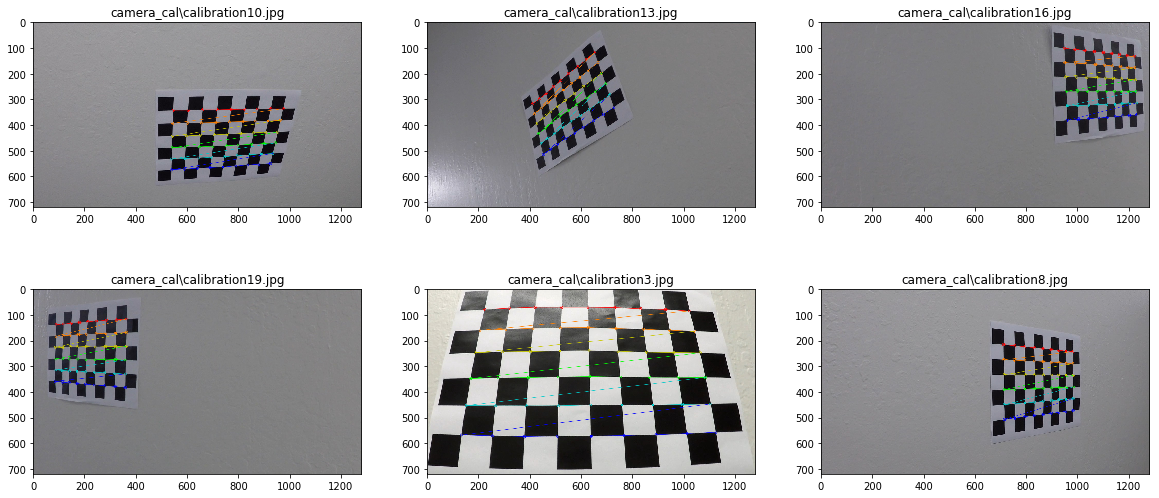

In [2]:

import cv2
import glob


n_corners = (9, 6)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((n_corners[0]*n_corners[1],3), np.float32)
objp[:,:2] = np.mgrid[0:n_corners[0], 0:n_corners[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
image_files = glob.glob('camera_cal/calibration*.jpg')

chessboardImages = []
chessboardNames = []
chessboardCornerNames = []
chessboardCornerImages = []
# Step through the list and search for chessboard corners
for idx, fname in enumerate(image_files):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    chessboardImages.append(img)
    chessboardNames.append(fname)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, n_corners, None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cornerImg = img.copy()
        cv2.drawChessboardCorners(cornerImg, n_corners, corners, ret)
        chessboardCornerImages.append(cornerImg)
        chessboardCornerNames.append(fname)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)

plot_image_array(chessboardCornerImages[::3], chessboardCornerNames[::3], ncols=3, nrows=2)

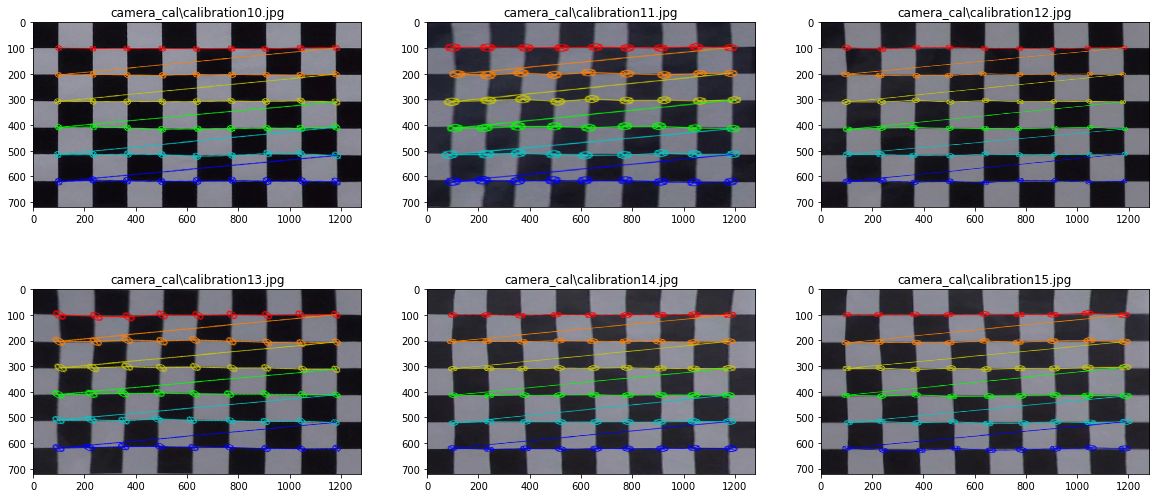

In [3]:
import pickle

img_size = (chessboardImages[0].shape[1], chessboardImages[0].shape[0])
# Do camera calibration given object points and image points
#print(objpoints)
#print(imgpoints)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None,None)

# Make a list of calibration images
# Step through the list and search for chessboard corners
undistortedImages = []
undistortedNames = []
for idx, img in enumerate(chessboardImages):

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    gray = cv2.cvtColor(undist, cv2.COLOR_BGR2GRAY)
    #undistortedImages.append(gray)
    #undistortedNames.append(chessboardNames[idx])
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, n_corners, None)
    
    # If corners found: 
    if ret:
        # a) draw corners
        cv2.drawChessboardCorners(undist, n_corners, corners, ret)
        # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
        offset = 100
        img_size = (undist.shape[1], undist.shape[0])
        src = np.float32([corners[0], corners[n_corners[0]-1], corners[-1], corners[-n_corners[0]]])

        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])


        # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # e) use cv2.warpPerspective() to warp your image to a top-down view
        warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
        undistortedImages.append(warped)
        undistortedNames.append(chessboardNames[idx])
        
plot_image_array(undistortedImages, undistortedNames, ncols=3, nrows=2)
        
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
cam_calibration = {}
cam_calibration["mtx"] = mtx
cam_calibration["dist"] = dist
pickle.dump( cam_calibration, open( "camera_calibration.p", 'wb'))

In [4]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if len(img.shape) > 2 else img
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output


# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def combined_channel_threshold(img, channels=[0, 1, 2], thresh=[(0, 255), (0, 255), (0, 255)], color_conversion = cv2.COLOR_BGR2HLS):
    if color_conversion:
        c = cv2.cvtColor(img, color_conversion)
    else:
        c = img       
    b = []
    for channel, t in zip(channels, thresh):
        s = c[:,:,channel]
        binary_output = np.zeros(s.shape, dtype=np.uint8)
        binary_output[(s >= t[0]) & (s <= t[1])] = 1
        b.append(binary_output)
    
    return np.minimum.reduce(np.dstack(tuple(b)), axis=2)

#combined = np.zeros_like(dir_binary)
#combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)

In [5]:
import os
import os.path

cam_calibration = pickle.load( open( "camera_calibration.p", "rb" ) )
print('Loaded camera calibration')
print('--------------------------')
print('mtx:\n', cam_calibration['mtx'])
print('\ndist:\n', cam_calibration['dist'])

def save_images(folder, images, names, binary=False):
    if not os.path.exists(folder):
        os.makedirs(folder)
    for img, fname in zip(images, names):
        p = os.path.join(folder, fname)
        if p[:-4] != '.jpg':
            p += '.jpg'
        if binary:
            img = img * 255
        cv2.imwrite(p, img)
    
def undistort_image(img):
    return cv2.undistort(img, cam_calibration['mtx'], cam_calibration['dist'], None, cam_calibration['mtx'])

Loaded camera calibration
--------------------------
mtx:
 [[  1.15396093e+03   0.00000000e+00   6.69705359e+02]
 [  0.00000000e+00   1.14802495e+03   3.85656232e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]

dist:
 [[ -2.41017968e-01  -5.30720497e-02  -1.15810318e-03  -1.28318543e-04
    2.67124302e-02]]


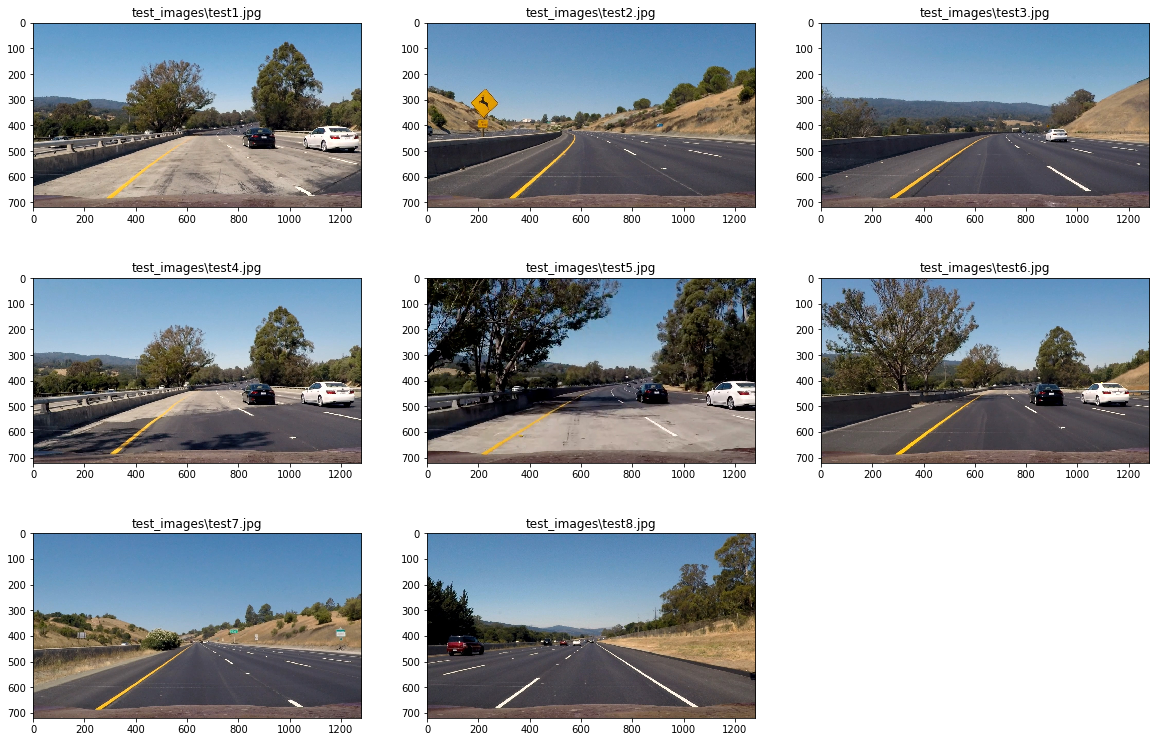

In [6]:

image_files = glob.glob('test_images/test*.jpg')

test = []
test_n = []
for idx, fname in enumerate(image_files):
    test.append(cv2.imread(fname))
    test_n.append(fname)
    
plot_image_array(test, test_n, ncols=3)   

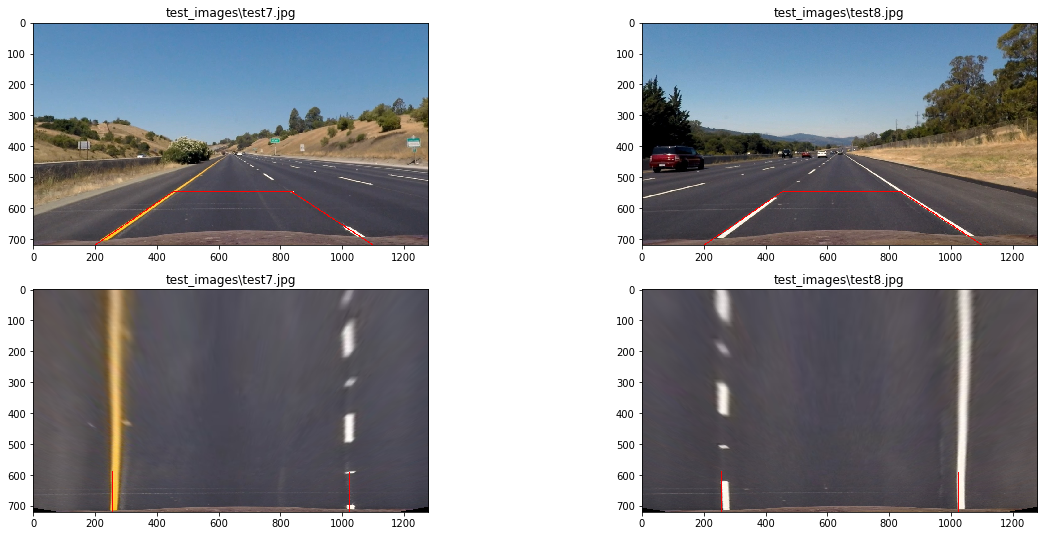

In [7]:
straight_image = test[6]
img_size = (straight_image.shape[1], straight_image.shape[0])

w,h = 1280,720
x,y = 0.6*w, 0.8*h
warp_src = np.float32([[200./1280*w,720./720*h],
              [453./1280*w,547./720*h],
              [835./1280*w,547./720*h],
              [1100./1280*w,720./720*h]])
warp_dst = np.float32([[(w-x)/2.,h],
              [(w-x)/2.,0.82*h],
              [(w+x)/2.,0.82*h],
              [(w+x)/2.,h]])

#warp_src = np.float32([[585, 460],
#                      [203, 720],
#                      [1127, 720],
#                      [695, 460]])

#warp_dst = np.float32([[320, 0],
#                      [320, 720],
#                      [960, 720],
#                      [960, 0]])


M_perspective = cv2.getPerspectiveTransform(warp_src.astype(np.float32), warp_dst.astype(np.float32))
Minv_perspective = cv2.getPerspectiveTransform(warp_dst.astype(np.float32), warp_src.astype(np.float32))

def draw_lines(src, lines, color = [0, 0, 255], thickness = 2, skip = False):
    img = src
    if len(img.shape) == 2:
        if np.max(src) <= 1:
            img = np.uint8(img.reshape((img.shape[0], img.shape[1], 1)) * 255)
            img = np.repeat(img, 3, axis=2)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    s = 2 if skip else 1
    for p in range(0, len(lines) - 1, s):
        cv2.line(img, tuple(lines[p].astype(int)), tuple(lines[p+1].astype(int)), color, thickness)
    return img
        

def warp_to_image_plane(img, M = M_perspective):
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped
    
out = []
out_n = []
for i in range(6, 8):
    c = draw_lines(undistort_image(test[i]), warp_src)
    out.append(c)
    out_n.append(test_n[i])
    
for i in range(6, 8):
    warped = warp_to_image_plane(undistort_image(test[i]), M_perspective)
    warped = draw_lines(warped, warp_dst, skip = True)
    out.append(warped)
    out_n.append(test_n[i])
    
plot_image_array(out, out_n, ncols=2)

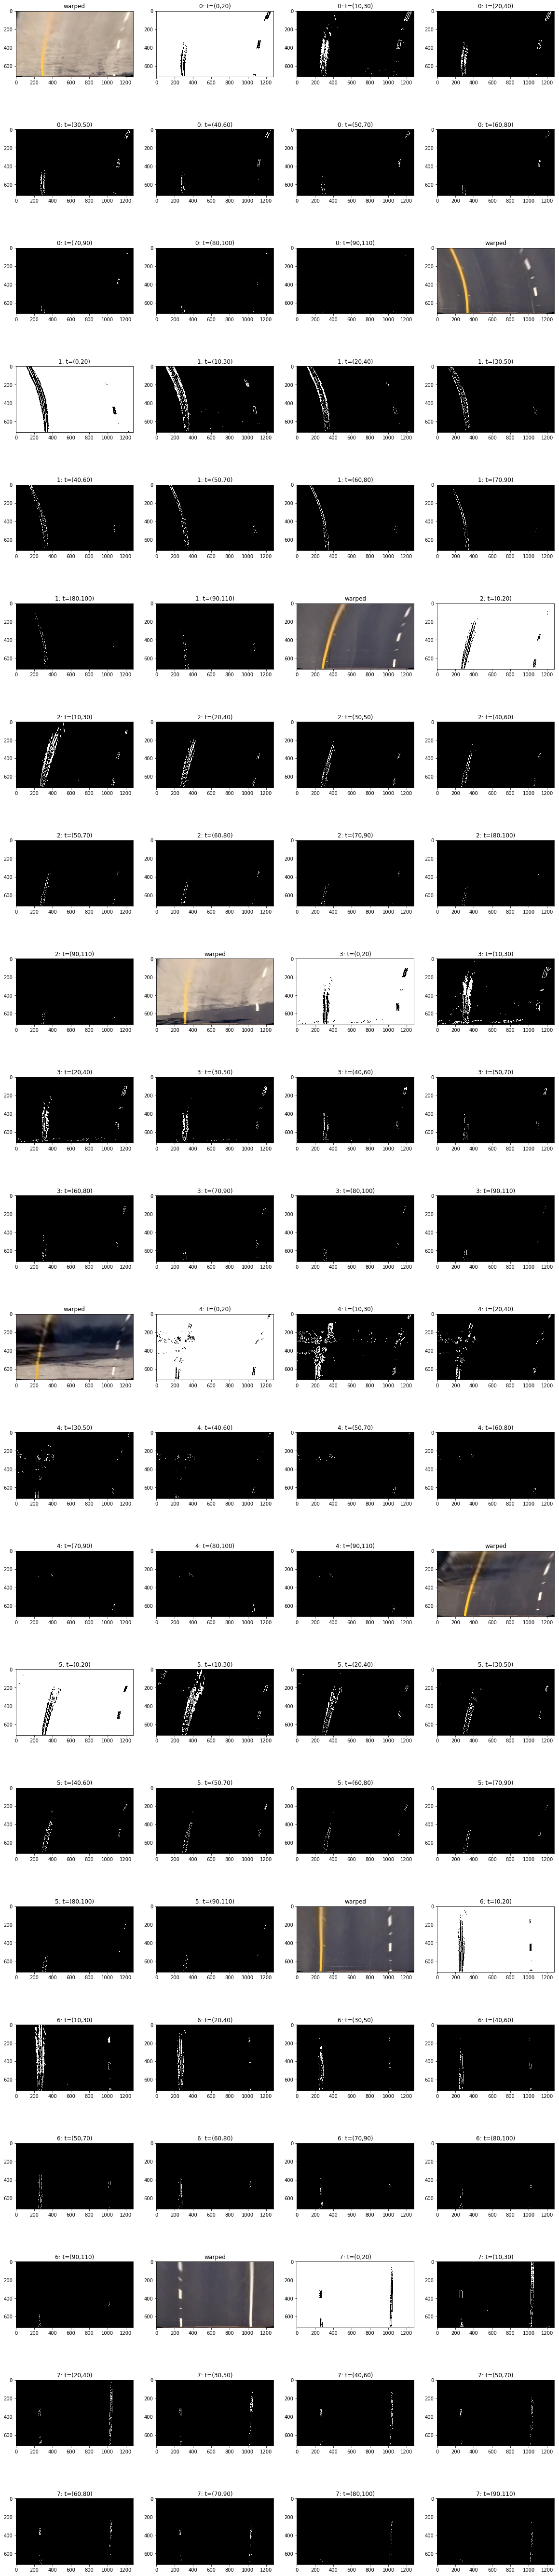

In [8]:
test_img = test[1]

# abs sobel x (5, 25, 100)
# mag thresh (9, 30, 100)
# dir sobel (15, 0.8, 1.2)
# s-channel (100, 255)
# l-channel (0, 100)


out = []
out_n = []
tmin = 0
tmax = 255
window = 20
step = 10
k = 5
i = 7
for i in range(0,8):
    #undistort image
    undistort = undistort_image(test[i])
    #out.append(undistort)
    #out_n.append(img_prefix + 'undistorted')

    # warp image
    warped = warp_to_image_plane(undistort)
    out.append(warped)
    out_n.append('warped')
    hls = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)
    for t in range(0, 100, step):
        t1 = t + window
        binary_gx = abs_sobel_thresh(hls[:,:,2], orient='x', sobel_kernel=7, thresh=(t, t1))
        out.append(binary_gx)
        out_n.append("{}: t=({},{})".format(i, t, t1))


#save_images('test_images/hls/l_t', out, out_n, binary=True)
plot_image_array(out, out_n, ncols=4)   

#imgplot = plt.imshow(out[0], cmap = 'gray')

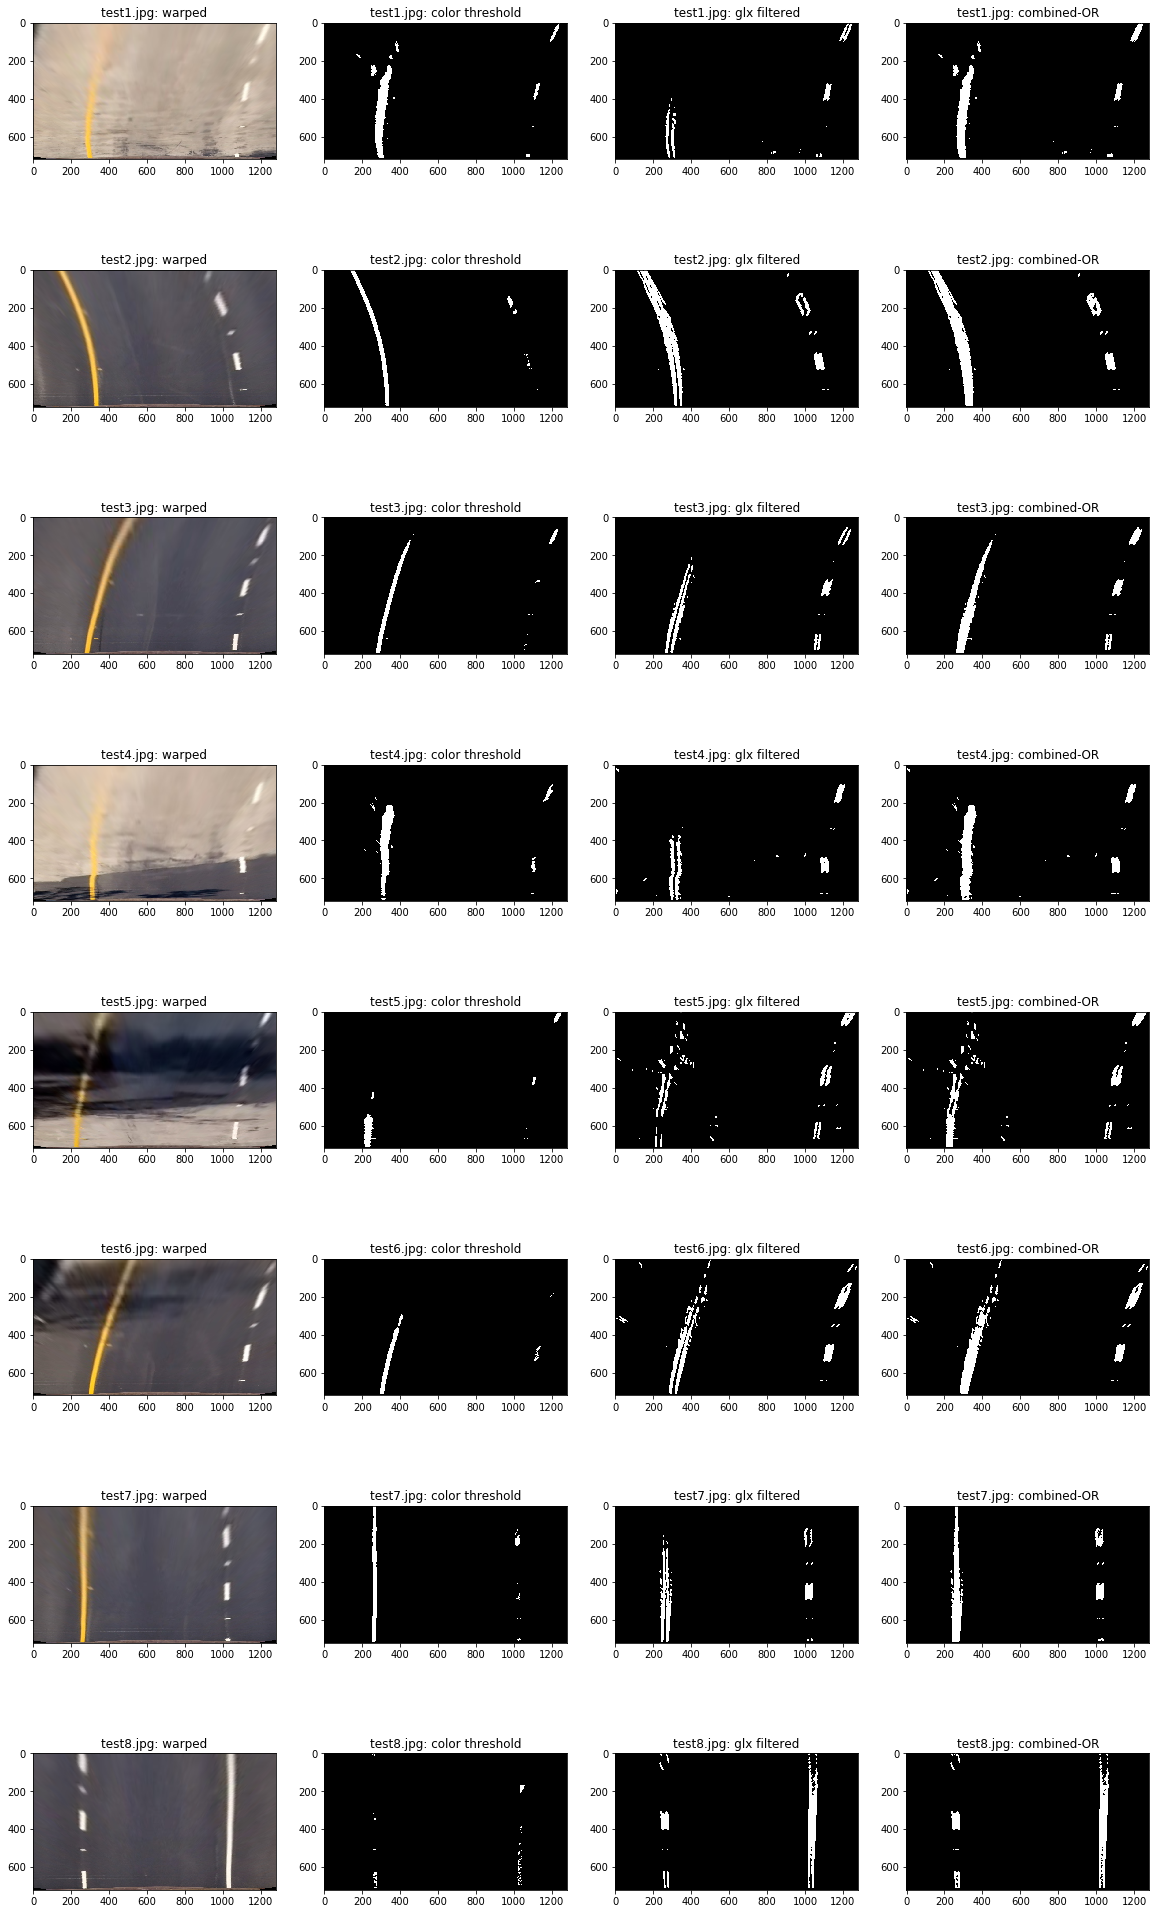

In [9]:


def preprocess_image(img, img_name = ''):
    out = []
    out_n = []
    
    img_prefix = img_name + ': '
    
    #undistort image
    undistort = undistort_image(img)

    # warp image
    warped = warp_to_image_plane(undistort)
    out.append(warped)
    out_n.append(img_prefix + 'warped')
    
    # apply color thresholds
    binary_hsv_yellow = combined_channel_threshold(warped, channels=[0, 1, 2], thresh=[(0, 40), (80, 255), (200, 255)], color_conversion = cv2.COLOR_BGR2HSV)   
    binary_hsv_white = combined_channel_threshold(warped, channels=[0, 1, 2], thresh=[(20, 255), (0, 80), (200, 255)], color_conversion = cv2.COLOR_BGR2HSV)

    # combine color thresholds for later demonstration
    binary_color = np.zeros_like(binary_hsv_white, dtype=np.uint8)
    binary_color[(binary_hsv_yellow == 1) | (binary_hsv_white == 1)] = 1
    out.append(binary_color)
    out_n.append(img_prefix + 'color threshold')
    
    # detect vertical lines with sobel in x-direction
    hls = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)
    binary_gx_l = abs_sobel_thresh(hls[:,:,1], orient='x', sobel_kernel=7, thresh=(40, 255))
    binary_gx_s = abs_sobel_thresh(hls[:,:,2], orient='x', sobel_kernel=7, thresh=(25, 255))
    
    # combine gradients for later demonstration
    binary_sobel = np.zeros_like(binary_gx_l, dtype=np.uint8)
    binary_sobel[(binary_gx_l == 1) | (binary_gx_s == 1)] = 1
    binary_gx_filtered = cv2.medianBlur(binary_sobel, 9) 
    out.append(binary_gx_filtered)
    out_n.append(img_prefix + 'glx filtered')  
    
    # combine all threshold images
    binary = np.zeros_like(binary_color)
    binary[(binary_color == 1) | (binary_gx_filtered == 1)] = 1
    out.append(binary)
    out_n.append(img_prefix + 'combined-OR')
    
    return undistort, binary, out, out_n

out = []
out_n = []
i=4
for i in range(len(test)):
    _, warped, o, o_n = preprocess_image(test[i], img_name = os.path.split(test_n[i])[-1])
    out += o
    out_n += o_n

plot_image_array(out, out_n, ncols=4) 

In [10]:
import operator

class SlidingWindow:

    def __init__(self, start_pos_x, image_height, n_windows = 9, window_margin = 100):
        self.window_height = np.int(image_height / n_windows)
        self.margin = window_margin
        self.image_height = image_height
        pos = []
        for p in start_pos_x:
            pos.append([(-1, p)])
        self.pos_x = tuple(pos)
        
    def set_window_x(self, level, window_index, window_pos_x):
        self.pos_x[window_index].append((level, window_pos_x))
    
    def get_window_y(self, level):
        y_high = self.image_height - level * self.window_height
        y_low = y_high - self.window_height
        return y_low, y_high
    
    def get_window_x(self, level, window_index):
        cur_lvl, cur_x = self.pos_x[window_index][-1]
        if cur_lvl > 0:
            diff = tuple(map(operator.sub, (cur_lvl, cur_x), self.pos_x[window_index][-2]))
            offset = (level - cur_lvl) * diff[1] / diff[0]
            cur_x += np.int(0.5 * offset)
        return cur_x - self.margin, cur_x + self.margin
            
        
#class Lane:
#    def __init__(self):
        
#class LanePair:
#    def __init__(self):
#        self.lanes(Lane(), Lane())
    

def detect_lanes(binary_warped):
    histogram = np.sum(warped[binary_warped.shape[0]//2:,:], axis=0)
    debug_img = np.dstack((binary_warped, binary_warped, binary_warped))*255    
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint    
    
    # Set minimum number of pixels found to recenter window
    minpix = 50
    n_windows = 9
    window = SlidingWindow(start_pos_x=[leftx_base, rightx_base], 
                           image_height=binary_warped.shape[0], 
                           n_windows=n_windows, 
                           window_margin=100)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for level in range(n_windows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low, win_y_high = window.get_window_y(level)
        win_xleft_low, win_xleft_high = window.get_window_x(level, 0)
        win_xright_low, win_xright_high = window.get_window_x(level, 1)
        
        # Draw the windows on the visualization image
        cv2.rectangle(debug_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(debug_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3)
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            window.set_window_x(level, 0, np.int(np.mean(nonzerox[good_left_inds])))
        if len(good_right_inds) > minpix:        
            window.set_window_x(level, 1, np.int(np.mean(nonzerox[good_right_inds])))


    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)


    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
 
    debug_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    debug_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.polylines(debug_img, np.int_([pts]), False, (0,255, 255), 3, cv2.LINE_AA)
 
    lane_img = np.zeros(debug_img.shape, dtype=np.uint8)
    cv2.fillPoly(lane_img, np.int_([pts]), (0,255, 0))
    
    return lane_img, debug_img, left_fit, right_fit


def track_lanes(binary_warped, left_fit, right_fit, margin = 100):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    #And you're done! But let's visualize the result here as well
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(out_img, np.int_([pts]), False, (0,255, 255), 3, cv2.LINE_AA)
    debug_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    lane_img = np.zeros(debug_img.shape, dtype=np.uint8)
    cv2.fillPoly(lane_img, np.int_([pts]), (0,255, 0))
    
    return lane_img, debug_img, left_fit, right_fit,

    
class LaneDetector:
    def __init__(self):
        self.current_left_fit = np.array([])
        self.current_right_fit = np.array([])
        
    def process_image(self, img):
        undist, warped, _, _ = preprocess_image(img)
        if len(self.current_left_fit) > 0 and len(self.current_right_fit) > 0:
            lane_img, debug_img, self.current_left_fit, self.current_right_fit = track_lanes(warped, self.current_left_fit, self.current_right_fit)
        else:
            lane_img, debug_img, self.current_left_fit, self.current_right_fit = detect_lanes(warped)
            
        newwarp = cv2.warpPerspective(lane_img, Minv_perspective, (undist.shape[1], undist.shape[0])) 
        # Combine the result with the original image
        lane_img = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        return lane_img

out = []
out_n = []
for i in range(len(test)):
    img_name = os.path.split(test_n[i])[-1]
    _, warped, _, _ = preprocess_image(test[i], img_name = img_name)
    _, img, _, _  = detect_lanes(warped)
    out.append(img)
    out_n.append(img_name)
    
#plot_image_array(out, out_n, ncols=2) 

## Helper Functions
The following helper functions are taken from the template notebook and might have been modified to fit my needs (e.g. draw_lines)

In [11]:
image_files = glob.glob('debug_images/video_*.jpg')

video = []
video_n = []
for idx, fname in enumerate(image_files):
    video.append(cv2.imread(fname))
    video_n.append(fname)

out = []
out_n = []
lane_detector = LaneDetector()
for i in range(len(video)):
    img_name = os.path.split(video_n[i])[-1]
    out.append(lane_detector.process_image(video[i]))
    out_n.append(img_name)
    
#plot_image_array(out, out_n, ncols=4) 

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`



In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
class VideoScraper:
    def __init__(self, folder = 'debug_images'):
        self.folder = folder
        self.img_counter = 0

    def save_video_image(self, img):
        if self.img_counter < 30:
            cv2.imwrite("debug_images/video_{:04d}.jpg".format(self.img_counter), cv2.cvtColor(img, cv2.COLOR_BGR2RGB));
            self.img_counter += 1

        return img


Let's try the one with the solid white lane on the right first ...

In [13]:
white_output = 'project_video_out.mp4'
clip1 = VideoFileClip("project_video.mp4")
#video_scraper = VideoScraper()
lane_detector = LaneDetector()
white_clip = clip1.fl_image(lane_detector.process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [06:51<00:00,  3.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 6min 52s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [16]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:22<00:00, 30.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 23.1 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))